In [144]:
from concurrent.futures import ThreadPoolExecutor
from typing import List, Tuple
import colorsys
import numpy as np
import matplotlib.pyplot as plt
import sk_dsp_comm.sigsys as ss
from numpy.typing import NDArray
from scipy.signal import find_peaks
import matplotlib.colors as colors
from scipy.signal import convolve2d

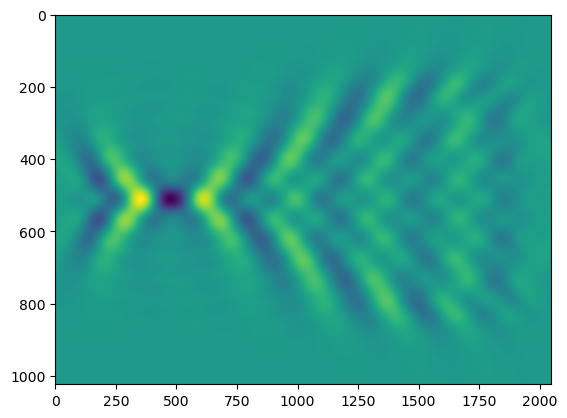

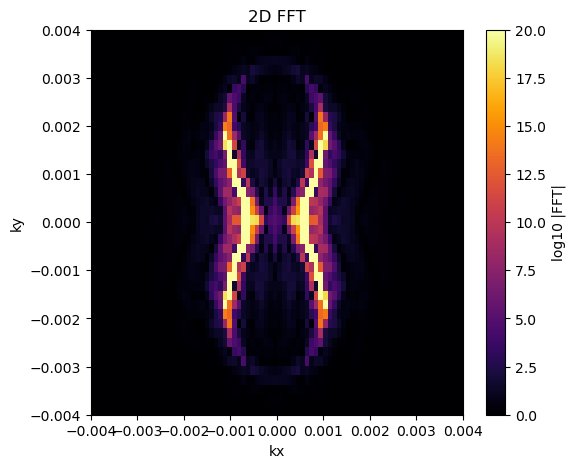

In [145]:
real_kevin = np.load("./kevin/realpunkt.npy")
imag_kevin = np.load("./kevin/imagpunkt.npy")
fullpunkt = np.zeros_like(real_kevin, dtype=np.complex128)
fullpunkt.real = real_kevin
fullpunkt.imag = imag_kevin
# pointSrc0 = filter_negWaveVectors(fullpunkt)
plt.imshow(np.real(fullpunkt)[:,:], aspect='auto')

Nx, Ny = fullpunkt.shape

fft2_result = np.fft.fft2(fullpunkt)
fft2_shifted = np.fft.fftshift(fft2_result)

kx = np.fft.fftfreq(Nx, d=5)
ky = np.fft.fftfreq(Ny, d=5)
kx = np.fft.fftshift(kx)
ky = np.fft.fftshift(ky)

magnitude = np.abs(fft2_shifted)
magnitude_log = np.log10(magnitude) 

plt.figure(figsize=(6, 5))
extent = (kx[0], kx[-1], ky[0], ky[-1])  # [kx_min, kx_max, ky_min, ky_max]
plt.imshow(magnitude, origin='lower', cmap='inferno', extent=extent, aspect='auto',vmin=0, vmax=20)
plt.colorbar(label="log10 |FFT|")
plt.xlim(-0.004, 0.004)
plt.ylim(-0.004, 0.004)
plt.title("2D FFT")
plt.xlabel("kx")
plt.ylabel("ky")
plt.show()

In [146]:
NP1DF8 = NDArray[np.float64]
NP2DF8 = NDArray[np.float64]
NP1DC16 = NDArray[np.complex128]
NP2DC16 = NDArray[np.complex128]
TT_TYPE = NDArray[np.int64]

def filter_negWaveVectors(M_yx: NP2DC16) -> NP2DC16:
    M_kq = np.fft.fft2(M_yx)
    kLen = int(M_kq.shape[1] / 2 + 1)
    zeros = np.zeros((M_kq.shape[0], kLen))
    M_kq[:, :kLen] = zeros
    M_yx_filtered = np.fft.ifft2(M_kq)
    M_yx_filtered /= np.amax(
        np.abs(M_yx_filtered[:, int(M_yx_filtered.shape[1] / 2 + 100)])
    )
    return M_yx_filtered

def initialize_point_src() -> NP2DC16:
    M_oop = np.load("./point_source_yig/point_source_2600_MHz_200_mT_OOP.npz")["M"]
    real_kevin = np.load("./kevin/realpunkt.npy")
    imag_kevin = np.load("./kevin/imagpunkt.npy")
    fullpunkt = np.zeros_like(real_kevin, dtype=np.complex128)
    fullpunkt.real = real_kevin
    fullpunkt.imag = imag_kevin
    pointSrc0 = filter_negWaveVectors(fullpunkt)
    return pointSrc0[:, int(pointSrc0.shape[1]/4) :]

def resonator_kevin() -> NP2DC16:
    real = np.load("./kevin/real.npy")
    imag = np.load("./kevin/imag.npy")
    full = np.zeros_like(real, dtype=np.complex128)
    full.real = real
    full.imag = imag
    return full

def resonator_PS() -> NP2DC16:
    M_oop = np.load("./point_source_yig/point_source_2600_MHz_200_mT_OOP.npz")["M"]
    return M_oop

def generate_rectangular_function(
    distance_between_inputs: int,
    unit_cell_size: int,
    number_of_inputs: int,
    input_width: int,
) -> Tuple[NP1DF8, NP1DF8, float]:
    d = distance_between_inputs / unit_cell_size
    s = input_width / unit_cell_size
    width = d * number_of_inputs
    x_int = np.arange(0, width, 1)
    rec = ss.rect(np.mod(x_int, d) - d/2, s)
    return rec, x_int, d

def calculate_analytic_signal(
    g_in: NP1DF8,
    x_int: NP1DF8,
    changed_src_numbers: List[int],
    input_phase_shift: float,
    active_input_amplitude: float,
):
    g_in_an = np.zeros_like(x_int, dtype=complex)
    b = 1
    for i in range(len(x_int)):
        if g_in[i] == 1 and (b in changed_src_numbers):
            phi_t = input_phase_shift
            Amp = active_input_amplitude
            if g_in[i + 1] == 0:
                b += 1
        elif g_in[i] == 1:
            phi_t = 0
            Amp = 1
            if g_in[i + 1] == 0:
                b += 1
        else:
            phi_t = 0
            Amp = 1
        g_in_an[i] = Amp * g_in[i] * np.exp(1j * phi_t)
        
    return g_in_an

def convolve_column(pointSrc: NP2DC16, g_in: NP1DC16, i: int) -> NP1DC16:
    return np.convolve(pointSrc[:, i], g_in, mode="full")

def convolve_columns(pointSrc: NP2DC16, g_in: NP1DC16) -> NP2DC16:
    newField = np.empty(
        (pointSrc.shape[0] + g_in.shape[0] - 1, pointSrc.shape[1]), dtype=np.complex128
    )
    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(convolve_column, pointSrc, g_in, i)
            for i in range(pointSrc.shape[1])
        ]
        for i, future in enumerate(futures):
            newField[:, i] = future.result()
    return newField

#-------

# def calculate_resonator_mask():
#     resonator_mask = np.zeros((100, 100), dtype=np.complex128)
#     resonator_mask[40:60, 40:60] = 1 + 0j
#     return resonator_mask

# def convolve_resonator2(res: NP2DC16, g_in: NP2DC16) -> NP2DC16:
#     newField = convolve2d(res, g_in, mode="full")
#     return newField

#-------

# def calculate_truth_table(
#     distance_between_inputs: float,
#     max_i: List[float], 
#     number_of_inputs: int,
#     input_width: int,
#     unite_cell_size: int
#     ) -> TT_TYPE:
#     truth_table = np.zeros(number_of_inputs-1)
#     for i in range(0, number_of_inputs-1):
#         if any((i+0.5)*distance_between_inputs + input_width/2
#                <= element*unite_cell_size <= 
#                (i+1.5)*distance_between_inputs - input_width/2 for element in max_i):
#             truth_table[i] = 1
#     return truth_table

def folding_field(arr_in, x_int, unit_cell_size):
    width = len(x_int)
    yShift = -2
    y0 = int(arr_in.shape[0]/2)
    nOfFolds = int(arr_in.shape[0]/width / 2)
    a_fld = arr_in[int(y0-0.5*width-yShift):int(y0+0.5*width-yShift),:]
    for i in range(1, nOfFolds):
        tmp = arr_in[int(y0+(i-0.5)*width-yShift):int(y0+(i+0.5)*width-yShift),:].copy()
        a_fld += tmp[::(-1)**abs(i),:]
        tmp = arr_in[int(y0+(-i-0.5)*width-yShift):int(y0+(-i+0.5)*width-yShift),:].copy()
        a_fld += tmp[::(-1)**abs(i),:]
    return a_fld[:,:]

def colourMode(mod, phase):
    mod = mod/np.amax(mod)
    array1 = np.zeros((phase.shape[0], phase.shape[1], 3))
    for y in range(phase.shape[0]):
        for x in range(phase.shape[1]):
            h = 0.5+phase[y,x]/(2*np.pi)  # angle
            l, s = (mod[y,x]), 1
            array1[y,x] = np.array(colorsys.hls_to_rgb(h, l, s))
    return array1

def center_align_res(res: np.ndarray, newField: np.ndarray, shift_x: int = 0, shift_y: int = 0) -> np.ndarray:

    Nx, Ny = newField.shape
    Px, Py = res.shape

    # Compute the effective "center" in res, shifted by shift_x and shift_y
    center_x = (Px // 2) - shift_x
    center_y = (Py // 2) - shift_y

    # Calculate start/end indices in 'res' to align the newField shape
    x_start_res = center_x - (Nx // 2)
    x_end_res   = x_start_res + Nx
    y_start_res = center_y - (Ny // 2)
    y_end_res   = y_start_res + Ny

    # Constrain within res boundaries to avoid out-of-bounds
    res_x_start_clamped = max(0, x_start_res)
    res_x_end_clamped   = min(Px, x_end_res)
    res_y_start_clamped = max(0, y_start_res)
    res_y_end_clamped   = min(Py, y_end_res)

    # Crop 'res' if it is larger than needed
    res_cropped = res[res_x_start_clamped:res_x_end_clamped, res_y_start_clamped:res_y_end_clamped]

    # Prepare an output array (same shape as newField) for zero-padding
    new_res = np.zeros((Nx, Ny), dtype=res.dtype)

    # Determine where the cropped portion goes in new_res
    # Shift in new_res if 'res_cropped' is smaller or if the indexing was clamped
    new_x_start = max(0, - (x_start_res))  # if x_start_res < 0, we shift in new_res
    new_y_start = max(0, - (y_start_res))  # if y_start_res < 0, we shift in new_res

    # Dimensions of the cropped region
    cropped_height = res_x_end_clamped - res_x_start_clamped
    cropped_width  = res_y_end_clamped - res_y_start_clamped

    # If there's overlap, place the cropped 'res' into new_res
    if cropped_height > 0 and cropped_width > 0:
        new_res[
            new_x_start : new_x_start + cropped_height,
            new_y_start : new_y_start + cropped_width
        ] = res_cropped

    return new_res, np.abs(cropped_width-new_x_start)//2, np.abs(cropped_width-new_y_start)//2

In [197]:
def logic_oop(
    number_of_inputs: int,
    distance_between_inputs: int,  # nm
    input_width: int,  # nm
    active_inputs: List[int],
    active_input_phase_shift: float,
    active_input_amplitude: float,
    unit_cell_size: int,  # nm
    # offset: int,
    w_axhl: int,
    x_size: int, #nm
    shift_res_x: int,
    shift_res_y: int,
    plots: bool = True,
    folding: bool = False
):
    
    # axhl = int(mid_line // unit_cell_size)
    x_size = int(x_size // unit_cell_size)

    pointSrc: NP2DC16 = initialize_point_src()
    res: NP2DC16 = resonator_kevin()

    g_in, x_int, d = generate_rectangular_function(
        distance_between_inputs,
        unit_cell_size,
        number_of_inputs,
        input_width,
    )

    g_in_c = calculate_analytic_signal(
        g_in,
        x_int,
        active_inputs,
        active_input_phase_shift,
        active_input_amplitude,
    )
    
    # res_mask = calculate_resonator_mask()

    newField: NP2DC16 = convolve_columns(pointSrc, g_in_c)
    newField /= np.amax(newField)
    SWs = np.abs(newField)
    res, center_x, center_y = center_align_res(res, newField, shift_res_y//unit_cell_size, shift_res_x//unit_cell_size)
    res/=np.amax(res)
    # newField =  res
    newField = np.add(newField, res)
    if folding:
        newField = folding_field(newField, x_int, unit_cell_size)[:,:x_size]
    else:
        newField = newField[int(pointSrc.shape[0] / 2) : -int(pointSrc.shape[0] / 2), :x_size]
        
    intensity = np.real(newField)**2 + np.imag(newField)**2
    intensity_res = np.real(res)**2 + np.imag(res)**2
    # intensity /= np.amax(np.abs(intensity[:, 20:-20]))
    
    # int_avg: NP1DF8 = np.mean(intensity[:, axhl - w_axhl : axhl + w_axhl], axis=1)
    # threshold = 0.8*int_avg.max()
    # max_i: List[float] = find_peaks(int_avg, height=threshold)[0]

    # truth_table = calculate_truth_table(distance_between_inputs, max_i, number_of_inputs, input_width, unit_cell_size)
    
    if plots:
        phase_2plot = np.angle(newField)
        mod_2plot = np.abs(newField)
        intentsity_1d_x = np.arange(0, intensity.shape[0], 1)
        # int_avg = np.mean(intensity[:, axhl - w_axhl:axhl + w_axhl], axis=1)
        # phase_1d_x = np.arange(0, intensity.shape[0], 1)
        # phase_1d = phase_2plot[:, axhl]
        # max_i = find_peaks(int_avg, height=threshold)[0]
        
        f0, ax = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={"width_ratios": [1, 4]})

        ax[0].plot(np.abs(g_in_c), x_int*unit_cell_size, color='k')
        ax[0].fill_between( 0, np.abs(g_in_c), x_int*unit_cell_size, color='#CCCCCC')
        ax[0].set_xlim(-0.1, 1.1)
        ax[0].set_xlabel("Amplitude")
        ax[0].set_ylabel("y (nm)")
        ax[0].set_ylim(0, number_of_inputs*distance_between_inputs)
        ax0a = ax[0].twiny()
        ax0a.plot(np.angle(g_in_c) * 180 / np.pi, x_int*unit_cell_size, color='maroon', ls='-', lw=4)
        ax0a.tick_params(axis='x', labelcolor='maroon')
        ax0a.set_xlabel("Phase (°)", color='maroon')
        ax0a.set_xlim(-190, 190)
        ax0a.set_xticks(range(-180, 190, 90))
        
        ax[1].imshow(np.flipud(colourMode(mod_2plot, phase_2plot)), aspect='auto', interpolation='sinc', extent=[0, x_size*unit_cell_size, 0, len(intentsity_1d_x)*unit_cell_size])
        # ax[1].axis('off')
        ax[1].tick_params(left=False, labelleft=False)
        ax[1].spines['left'].set_visible(False)
        ax[1].set_xlabel("x (nm)")
        
        for i in range(number_of_inputs):
            ax[0].text(
                    1.03, 0.055+i*0.111, 
                    f"[{i+1}]", 
                    transform=ax[0].transAxes, 
                    ha="center", 
                    va="center", 
                    color="blue", 
                    fontweight="bold",
                    fontsize=15,
                    bbox=dict(facecolor="white",edgecolor="none",alpha=0.8),
                    zorder=10
                    )
        # ax[1].axvline(center_x * unit_cell_size, color='red', lw=2)
        # ax[1].axhline(center_y * unit_cell_size, color='red', lw=2)

        
        #-------------------------------------------------------------------------------------------
        plt.figure(figsize=(12, 5))
        
        plt.subplot(121)
        im =plt.imshow(SWs, vmax=1, aspect='auto', extent=[0, x_size*unit_cell_size, 0, len(intentsity_1d_x)*unit_cell_size])
        plt.colorbar(im, label="Intensity")
        plt.title("Spin waves")

        plt.subplot(122)
        im =plt.imshow(intensity_res, vmax=1, aspect='auto', extent=[0, x_size*unit_cell_size, 0, len(intentsity_1d_x)*unit_cell_size])
        plt.colorbar(im, label="Intensity")
        plt.title("Rezonator")
        
        
        plt.figure(figsize=(12, 5))
        
        plt.subplot(121)
        im =plt.imshow(intensity, vmax=1, aspect='auto', extent=[0, x_size*unit_cell_size, 0, len(intentsity_1d_x)*unit_cell_size])
        plt.colorbar(im, label="Intensity")
        plt.title("Interference")
        # ax1[0].axvline(axhl*unit_cell_size, color='red', lw=w_axhl, alpha=0.4)
        # ax[0].set_xlabel("x (nm)")
        # ax[0].set_ylabel("y (nm)")
        # for i in range(0, number_of_inputs):
        #     ax1[0].axhline(distance_between_inputs/unit_cell_size * ((i+0.5)*unit_cell_size), color='yellow', lw=2, alpha=0.4, xmin=0.2, xmax=0.5)
            
        # ax1[1].set_ylim(0, 1)
        # ax1[1].plot(intentsity_1d_x*unit_cell_size, int_avg, linewidth=3, color='blue')
        # ax[1].set_ylabel("Amplitude")
        # ax1[1].axhline(threshold, color='orange', ls='--')
        # for i in range(0, number_of_inputs-1):
        #     ax1[1].text(distance_between_inputs/unit_cell_size * (i+1)*unit_cell_size, 0.8, f"{int(truth_table[i])}", color='black', fontsize=12, ha='center')
        # for i in range(0, number_of_inputs):
        #     ax1[1].axhline(distance_between_inputs/unit_cell_size * (i+0.5)*unit_cell_size, color='orange', lw=2, alpha=0.4)
        # for j in max_i:
        #     ax1[1].scatter(int_avg[j], j*unit_cell_size, zorder=3, color='red')

        plt.tight_layout()
        plt.show()

    # return truth_table

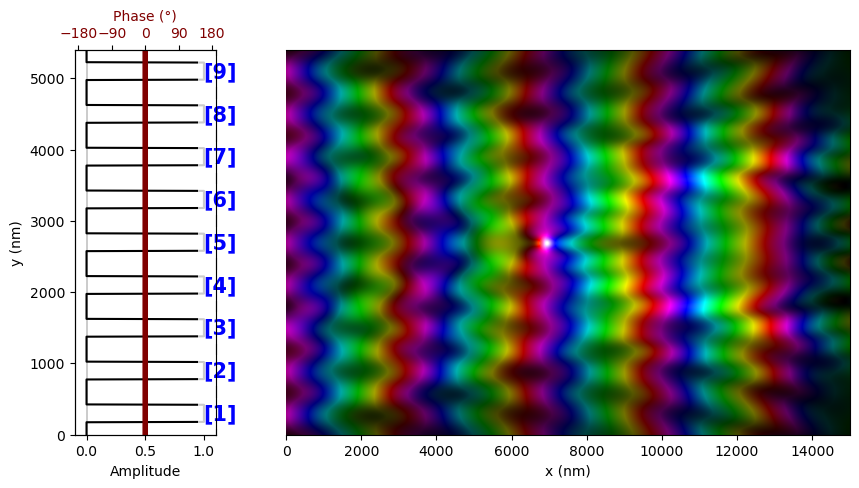

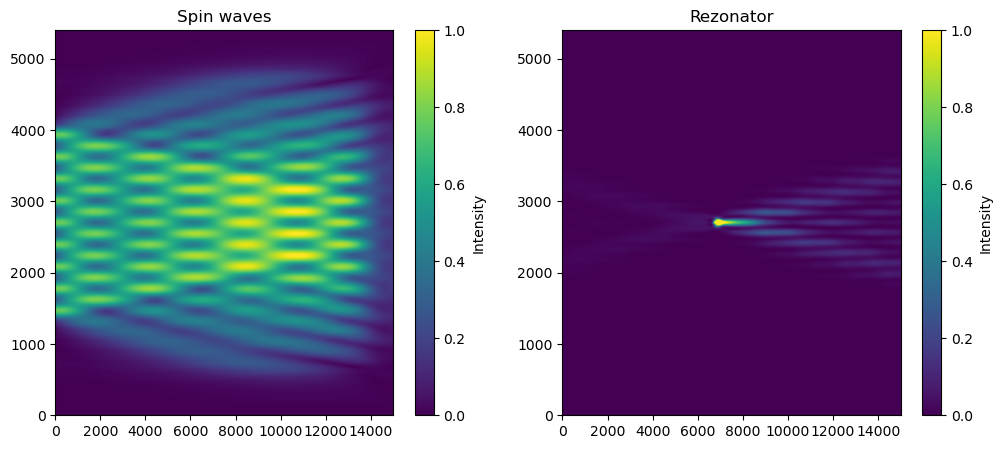

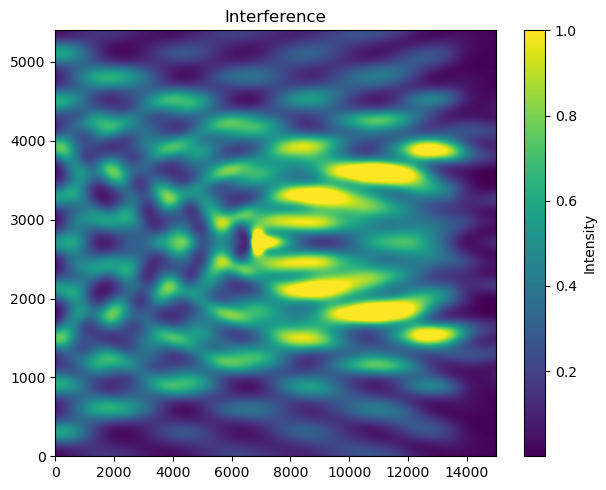

In [198]:
if __name__ == "__main__":
    tt = logic_oop(
        number_of_inputs=9,
        distance_between_inputs=600,  # nm
        input_width=240,  # nm
        active_inputs=[],
        active_input_phase_shift=np.pi,
        active_input_amplitude= 1,  # 1 -> unchanged
        unit_cell_size=5,  # nm
        w_axhl=10,
        x_size=15000, #nm
        shift_res_x=0,
        shift_res_y=0,
        plots=True,
        folding=True
        )